# Gold Price Historical Data: Exploratory Data Analysis (EDA)

This notebook provides a comprehensive first-pass EDA for the 10-year gold price dataset.

**Objectives**
- Validate data quality and structural consistency
- Profile distributions and key descriptive statistics
- Analyze trend, seasonality, volatility, and drawdowns
- Examine relationships between price action and trading volume

In [3]:
import os
from pathlib import Path

# Keep matplotlib cache writable in restricted environments.
os.environ.setdefault("MPLCONFIGDIR", "/tmp/mpl-cache")

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

# Dataset is in project root; notebook may run from project root or from notebooks/
_DATA_PATH = Path("gold_historical_data.csv")
DATA_PATH = _DATA_PATH if _DATA_PATH.exists() else Path("../gold_historical_data.csv")
SEED = 42
np.random.seed(SEED)

In [4]:
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found: {DATA_PATH.resolve()}")

df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")

df.head()

Shape: 2,510 rows x 7 columns
Date range: 2016-02-05 to 2026-01-30


,Date,Adj Close,Close,High,Low,Open,Volume
0,2016-02-05,"1,157.800049","1,157.800049","1,174.800049","1,146.000000","1,155.599976",877
1,2016-02-08,"1,197.900024","1,197.900024","1,200.400024","1,165.000000","1,173.500000",931
2,2016-02-09,"1,198.699951","1,198.699951","1,199.199951","1,186.699951","1,188.699951",700
3,2016-02-10,"1,194.699951","1,194.699951","1,197.699951","1,182.099976","1,189.800049",671
4,2016-02-11,"1,247.900024","1,247.900024","1,260.800049","1,204.599976","1,205.599976",995


In [5]:
overview = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum().values,
    "nulls": df.isna().sum().values,
    "n_unique": df.nunique().values,
})
overview

,dtype,non_null,nulls,n_unique
Date,datetime64[ns],2510,0,2510
Adj Close,float64,2510,0,2186
Close,float64,2510,0,2186
High,float64,2510,0,2186
Low,float64,2510,0,2190
Open,float64,2510,0,2180
Volume,int64,2510,0,1077


In [6]:
quality_checks = {
    "duplicate_rows": int(df.duplicated().sum()),
    "duplicate_dates": int(df["Date"].duplicated().sum()),
    "missing_cells": int(df.isna().sum().sum()),
}

ohlc_consistency = (
    (df["High"] >= df[["Open", "Close", "Low"]].max(axis=1))
    & (df["Low"] <= df[["Open", "Close", "High"]].min(axis=1))
)
quality_checks["ohlc_consistency_failures"] = int((~ohlc_consistency).sum())

pd.Series(quality_checks, name="count").to_frame()

,count
duplicate_rows,0
duplicate_dates,0
missing_cells,0
ohlc_consistency_failures,0


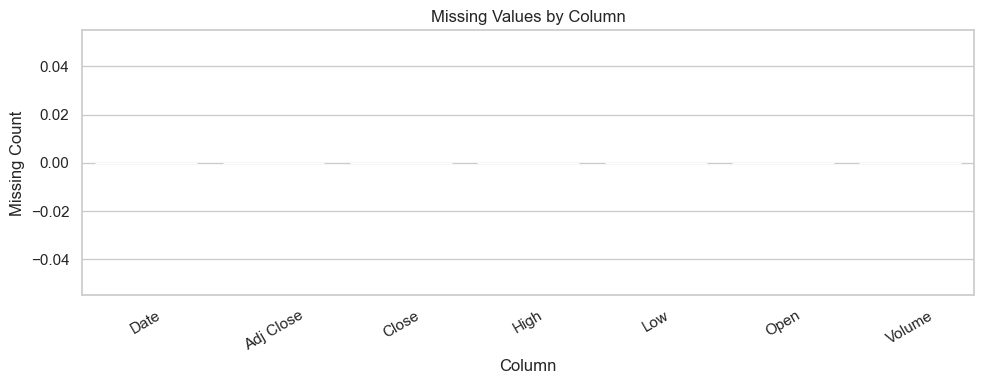

In [7]:
missing_counts = df.isna().sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x=missing_counts.index, y=missing_counts.values, ax=ax, color="steelblue")
ax.set_title("Missing Values by Column")
ax.set_xlabel("Column")
ax.set_ylabel("Missing Count")
ax.tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.show()

## Feature Engineering

Core features used in financial EDA:
- `Return`: close-to-close percentage return
- `LogReturn`: log return for additive properties
- `Range`: intraday high-low spread
- `Body`: absolute open-close candle body
- `Rolling20`, `Rolling50`, `Rolling200`: trend smoothing windows
- `Volatility30`: 30-day annualized rolling volatility
- `Drawdown`: peak-to-trough decline from cumulative return

In [8]:
df["Return"] = df["Close"].pct_change()
df["LogReturn"] = np.log(df["Close"]).diff()
df["Range"] = df["High"] - df["Low"]
df["Body"] = (df["Close"] - df["Open"]).abs()

df["Rolling20"] = df["Close"].rolling(20).mean()
df["Rolling50"] = df["Close"].rolling(50).mean()
df["Rolling200"] = df["Close"].rolling(200).mean()
df["Volatility30"] = df["Return"].rolling(30).std() * np.sqrt(252)

df["CumReturn"] = (1 + df["Return"].fillna(0)).cumprod()
df["RollingMax"] = df["CumReturn"].cummax()
df["Drawdown"] = df["CumReturn"] / df["RollingMax"] - 1

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["MonthName"] = df["Date"].dt.strftime("%b")
df["Weekday"] = df["Date"].dt.day_name()

df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Return,LogReturn,Range,Body,Rolling20,Rolling50,Rolling200,Volatility30,CumReturn,RollingMax,Drawdown,Year,Month,MonthName,Weekday
0,2016-02-05,"1,157.800049","1,157.800049","1,174.800049","1,146.000000","1,155.599976",877,NaN,NaN,28.800049,2.200073,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,2016,2,Feb,Friday
1,2016-02-08,"1,197.900024","1,197.900024","1,200.400024","1,165.000000","1,173.500000",931,0.034635,0.034048,35.400024,24.400024,NaN,NaN,NaN,NaN,1.034635,1.034635,0.000000,2016,2,Feb,Monday
2,2016-02-09,"1,198.699951","1,198.699951","1,199.199951","1,186.699951","1,188.699951",700,0.000668,0.000668,12.500000,10.000000,NaN,NaN,NaN,NaN,1.035326,1.035326,0.000000,2016,2,Feb,Tuesday
3,2016-02-10,"1,194.699951","1,194.699951","1,197.699951","1,182.099976","1,189.800049",671,-0.003337,-0.003343,15.599976,4.899902,NaN,NaN,NaN,NaN,1.031871,1.035326,-0.003337,2016,2,Feb,Wednesday
4,2016-02-11,"1,247.900024","1,247.900024","1,260.800049","1,204.599976","1,205.599976",995,0.044530,0.043567,56.200073,42.300049,NaN,NaN,NaN,NaN,1.077820,1.077820,0.000000,2016,2,Feb,Thursday


In [9]:
stats_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Return", "Range", "Body", "Volatility30", "Drawdown"
]

stats = df[stats_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T
stats

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Open,"2,510.000000","1,862.260478",712.946710,"1,126.900024","1,173.809047","1,214.589978","1,306.224976","1,768.049988","1,969.325012","3,367.330054","4,350.555098","5,415.700195"
High,"2,510.000000","1,872.036176",719.366255,"1,132.800049","1,181.388960","1,221.400024","1,310.325043","1,777.200012","1,978.375031","3,389.054956","4,363.583813","5,586.200195"
Low,"2,510.000000","1,852.944064",706.561716,"1,123.900024","1,168.008020","1,209.379962","1,301.624969","1,759.900024","1,960.599976","3,350.794995","4,327.921187","5,301.600098"
Close,"2,510.000000","1,862.680556",713.045002,"1,127.800049","1,175.198973","1,214.890027","1,306.224976","1,767.350037","1,968.975006","3,376.214929","4,346.780000","5,318.399902"
Volume,"2,510.000000","5,161.460558","28,443.386437",0.000000,0.000000,5.000000,53.250000,213.000000,655.500000,"5,953.150000","189,728.580000","386,334.000000"
Return,"2,509.000000",0.000610,0.010030,-0.113662,-0.026495,-0.015559,-0.004077,0.000672,0.005835,0.015815,0.027735,0.059477
Range,"2,510.000000",19.092112,25.684343,0.000000,0.000000,0.000000,7.000000,13.600098,23.674957,52.854968,101.282053,740.500000
Body,"2,510.000000",11.462949,19.791166,0.000000,0.000000,0.000000,2.299957,6.699951,14.500000,37.410022,73.464009,662.500000
Volatility30,"2,480.000000",0.144551,0.051791,0.068639,0.075801,0.086944,0.109324,0.136707,0.163466,0.233356,0.353546,0.434465
Drawdown,"2,510.000000",-0.061542,0.047699,-0.208725,-0.187159,-0.148686,-0.097295,-0.053235,-0.022773,0.000000,0.000000,0.000000


## Price Trend and Volume Dynamics

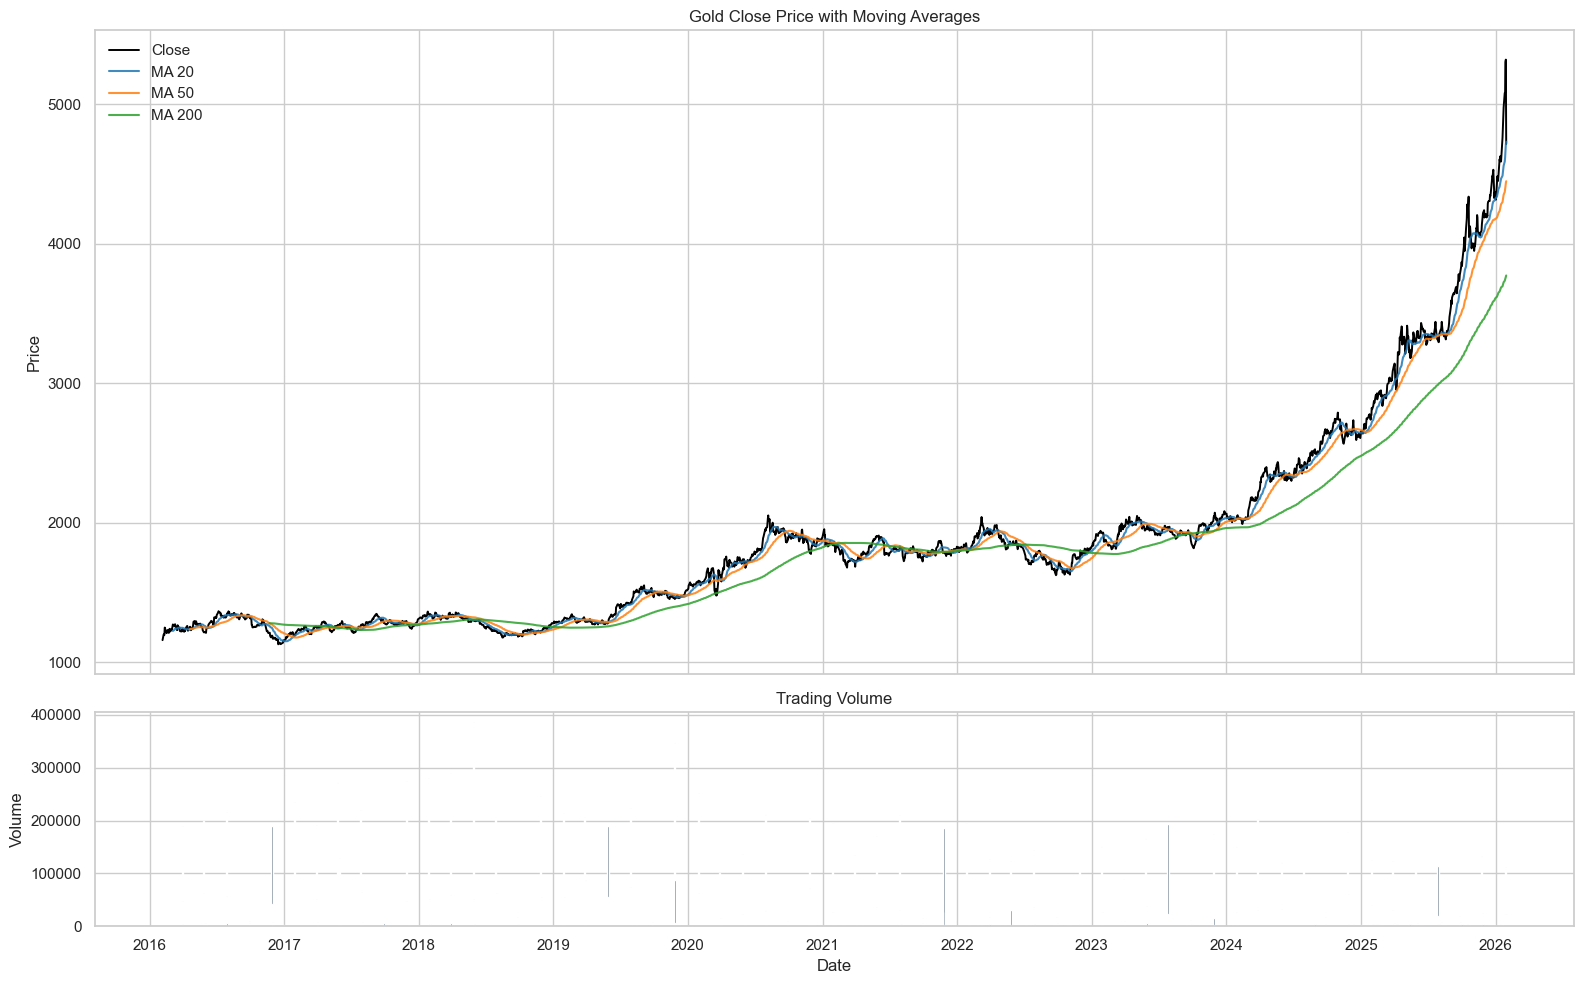

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={"height_ratios": [3, 1]})

axes[0].plot(df["Date"], df["Close"], label="Close", color="black", linewidth=1.4)
axes[0].plot(df["Date"], df["Rolling20"], label="MA 20", color="tab:blue", alpha=0.85)
axes[0].plot(df["Date"], df["Rolling50"], label="MA 50", color="tab:orange", alpha=0.85)
axes[0].plot(df["Date"], df["Rolling200"], label="MA 200", color="tab:green", alpha=0.85)
axes[0].set_title("Gold Close Price with Moving Averages")
axes[0].set_ylabel("Price")
axes[0].legend(loc="upper left")

axes[1].bar(df["Date"], df["Volume"], color="slategray", width=3)
axes[1].set_title("Trading Volume")
axes[1].set_ylabel("Volume")
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()

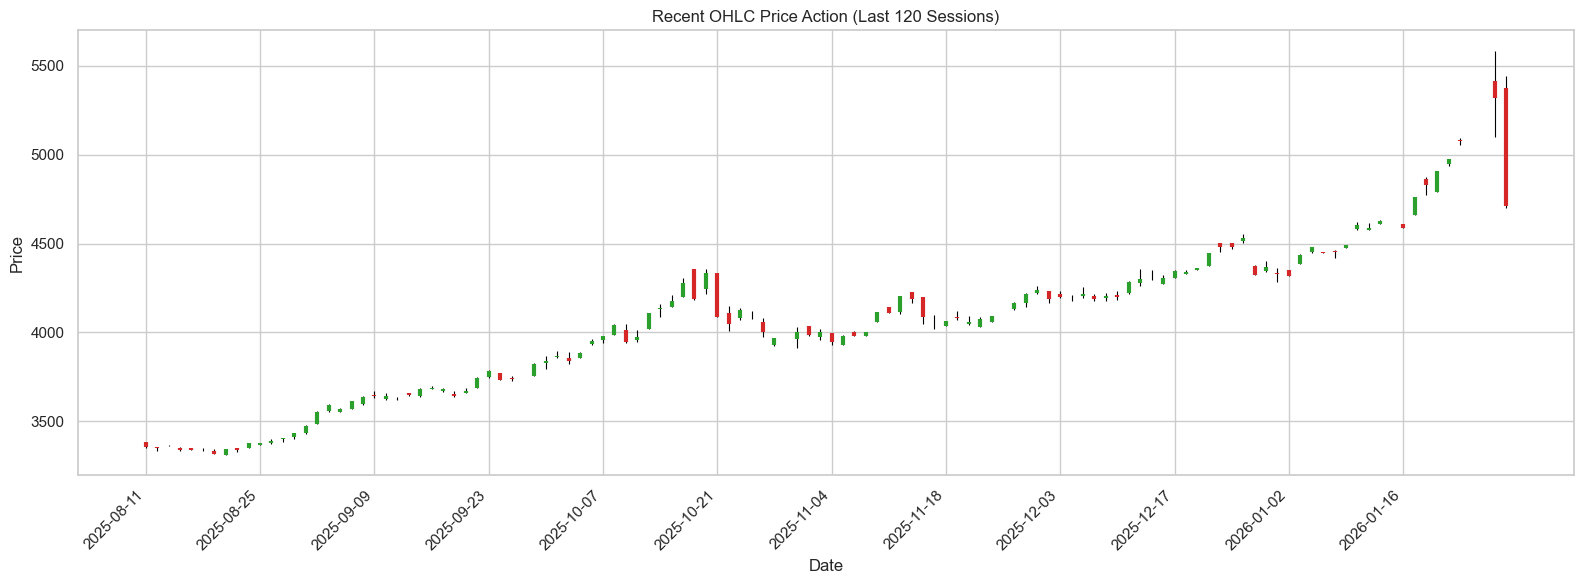

In [11]:
# Lightweight candlestick-like visualization for recent sessions (no extra dependency required).
recent = df.tail(120).copy().reset_index(drop=True)

fig, ax = plt.subplots(figsize=(16, 6))
for i, row in recent.iterrows():
    color = "tab:green" if row["Close"] >= row["Open"] else "tab:red"
    ax.vlines(i, row["Low"], row["High"], color="black", linewidth=0.8)
    ax.vlines(i, row["Open"], row["Close"], color=color, linewidth=3)

step = 10
ticks = np.arange(0, len(recent), step)
labels = recent.loc[ticks, "Date"].dt.strftime("%Y-%m-%d")
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("Recent OHLC Price Action (Last 120 Sessions)")
ax.set_ylabel("Price")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

## Distribution and Outlier Analysis

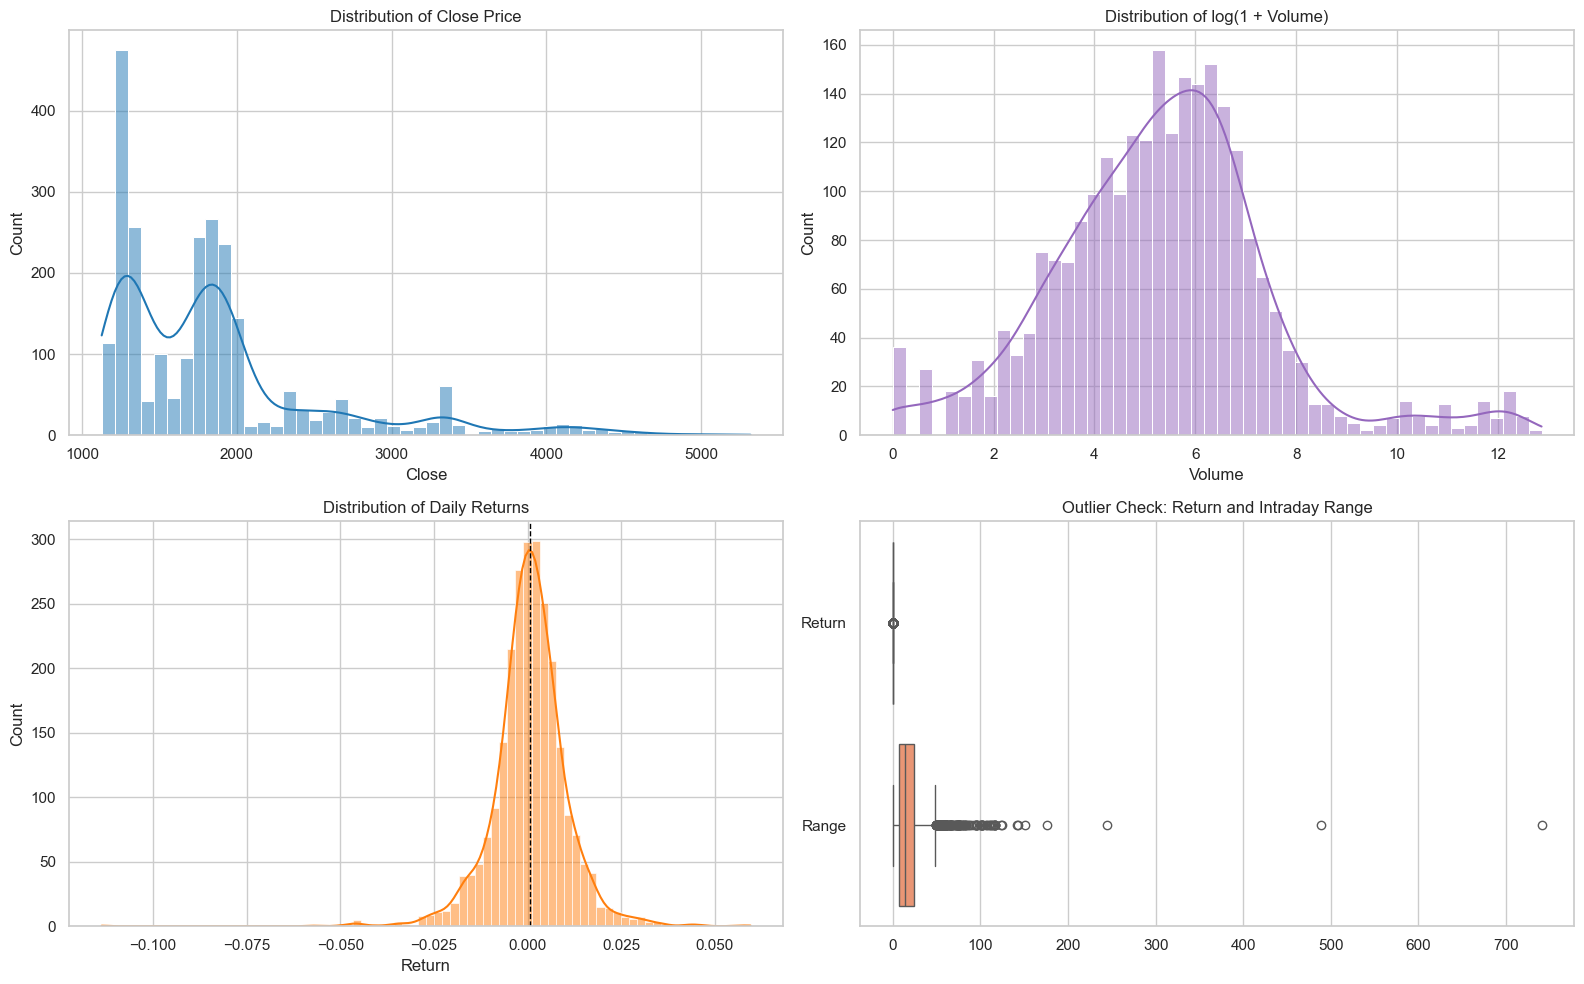

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.histplot(df["Close"], bins=50, kde=True, ax=axes[0, 0], color="tab:blue")
axes[0, 0].set_title("Distribution of Close Price")

sns.histplot(np.log1p(df["Volume"]), bins=50, kde=True, ax=axes[0, 1], color="tab:purple")
axes[0, 1].set_title("Distribution of log(1 + Volume)")

sns.histplot(df["Return"].dropna(), bins=80, kde=True, ax=axes[1, 0], color="tab:orange")
axes[1, 0].axvline(df["Return"].mean(), color="black", linestyle="--", linewidth=1)
axes[1, 0].set_title("Distribution of Daily Returns")

sns.boxplot(data=df[["Return", "Range"]], ax=axes[1, 1], orient="h", palette="Set2")
axes[1, 1].set_title("Outlier Check: Return and Intraday Range")

plt.tight_layout()
plt.show()

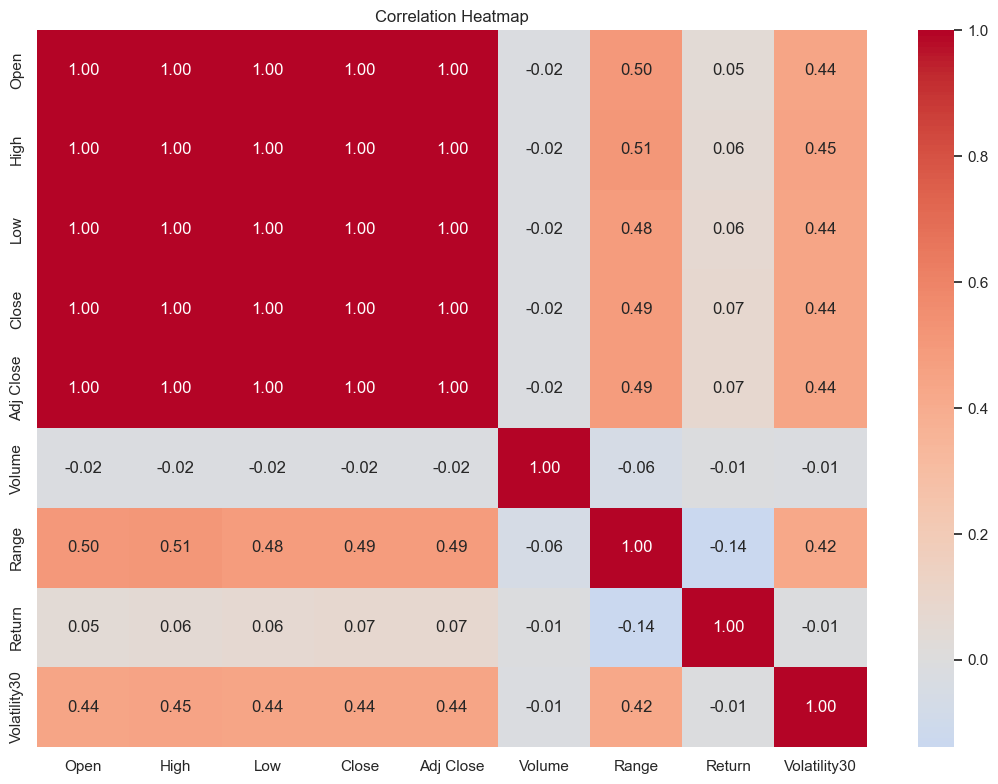

In [13]:
corr_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume", "Range", "Return", "Volatility30"]
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(11, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

## Seasonality and Regime Views

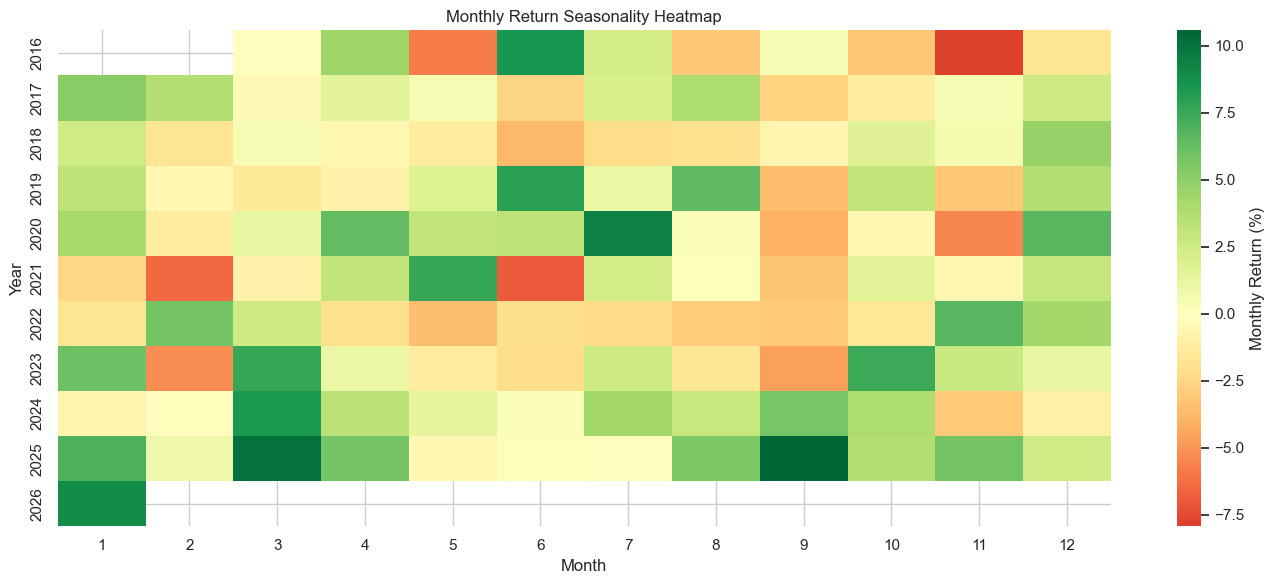

In [14]:
monthly_close = df.set_index("Date")["Close"].resample("ME").last()
monthly_return = monthly_close.pct_change()

seasonality = monthly_return.to_frame(name="MonthlyReturn")
seasonality["Year"] = seasonality.index.year
seasonality["Month"] = seasonality.index.month

pivot = seasonality.pivot(index="Year", columns="Month", values="MonthlyReturn")

plt.figure(figsize=(14, 6))
sns.heatmap(pivot * 100, cmap="RdYlGn", center=0, annot=False, cbar_kws={"label": "Monthly Return (%)"})
plt.title("Monthly Return Seasonality Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

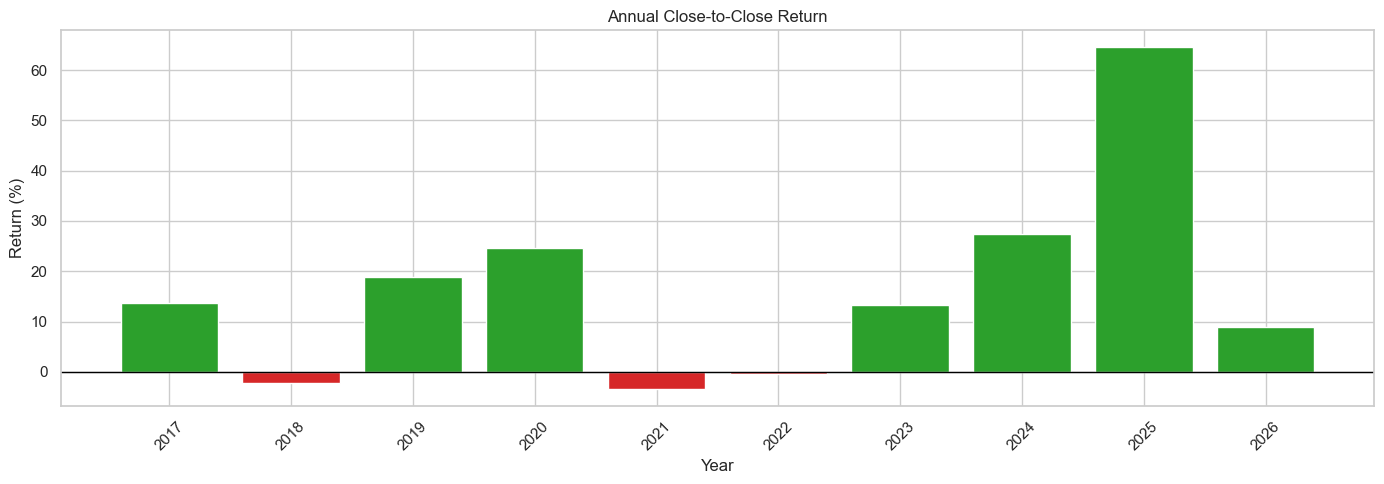

,AnnualReturn
Date,
2017-12-31,0.135913
2018-12-31,-0.021435
2019-12-31,0.188688
2020-12-31,0.245870
2021-12-31,-0.034652
2022-12-31,-0.004268
2023-12-31,0.133374
2024-12-31,0.274825
2025-12-31,0.645215


In [15]:
annual_return = df.set_index("Date")["Close"].resample("YE").last().pct_change().dropna()

fig, ax = plt.subplots(figsize=(14, 5))
colors = ["tab:green" if x >= 0 else "tab:red" for x in annual_return.values]
ax.bar(annual_return.index.year.astype(str), annual_return.values * 100, color=colors)
ax.axhline(0, color="black", linewidth=1)
ax.set_title("Annual Close-to-Close Return")
ax.set_ylabel("Return (%)")
ax.set_xlabel("Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

annual_return.to_frame(name="AnnualReturn")

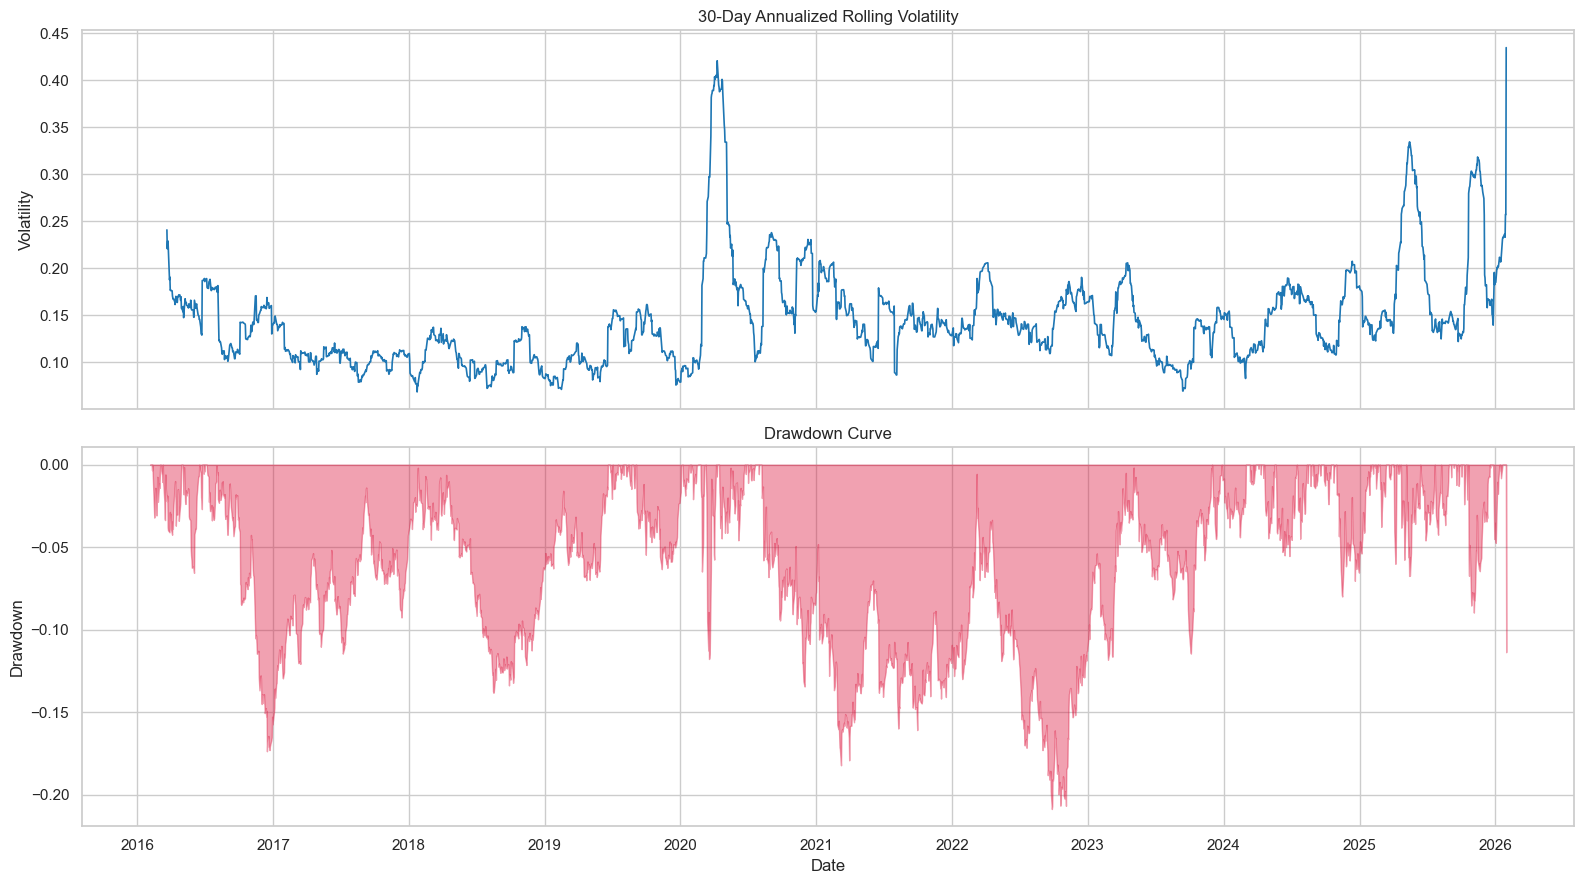

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

axes[0].plot(df["Date"], df["Volatility30"], color="tab:blue", linewidth=1.2)
axes[0].set_title("30-Day Annualized Rolling Volatility")
axes[0].set_ylabel("Volatility")

axes[1].fill_between(df["Date"], df["Drawdown"], 0, color="crimson", alpha=0.4)
axes[1].set_title("Drawdown Curve")
axes[1].set_ylabel("Drawdown")
axes[1].set_xlabel("Date")

plt.tight_layout()
plt.show()

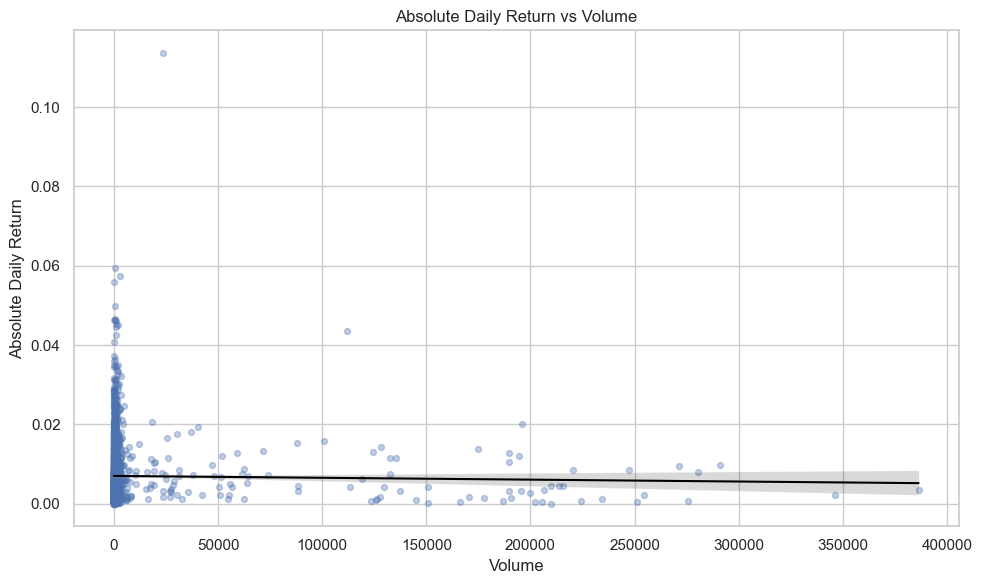

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(
    data=df,
    x="Volume",
    y=df["Return"].abs(),
    scatter_kws={"alpha": 0.35, "s": 18},
    line_kws={"color": "black", "linewidth": 1.5},
    ax=ax,
)
ax.set_title("Absolute Daily Return vs Volume")
ax.set_ylabel("Absolute Daily Return")
plt.tight_layout()
plt.show()

In [18]:
extreme_moves = (
    df.loc[df["Return"].abs().nlargest(10).index, ["Date", "Open", "High", "Low", "Close", "Volume", "Return"]]
    .sort_values(by="Return", key=lambda s: s.abs(), ascending=False)
    .reset_index(drop=True)
)
extreme_moves

,Date,Open,High,Low,Close,Volume,Return
0,2026-01-30,"5,376.399902","5,440.500000","4,700.000000","4,713.899902",23709,-0.113662
1,2020-03-24,"1,592.699951","1,685.500000","1,592.699951","1,660.199951",442,0.059477
2,2025-10-21,"4,332.700195","4,332.700195","4,087.699951","4,087.699951",2943,-0.057352
3,2020-03-23,"1,505.300049","1,567.000000","1,490.199951","1,567.000000",51,0.055930
4,2020-11-09,"1,955.599976","1,963.199951","1,847.099976","1,853.199951",745,-0.049787
5,2016-06-24,"1,253.699951","1,355.599976","1,253.699951","1,320.000000",694,0.046622
6,2020-03-13,"1,574.900024","1,589.800049","1,513.800049","1,515.699951",89,-0.046310
7,2020-02-28,"1,640.300049","1,642.500000","1,564.099976","1,564.099976",289,-0.046281
8,2021-06-17,"1,811.800049","1,823.300049","1,769.599976","1,773.800049",1135,-0.046088
9,2020-08-11,"2,012.400024","2,016.000000","1,904.000000","1,932.599976",971,-0.045347


## Key EDA Summary

The following metrics provide a concise quantitative summary for downstream modeling and forecasting.

In [19]:
trading_days = max(len(df) - 1, 1)
years_approx = trading_days / 252
cagr = (df["Close"].iloc[-1] / df["Close"].iloc[0]) ** (1 / years_approx) - 1

summary = pd.Series({
    "rows": int(len(df)),
    "columns": int(df.shape[1]),
    "start_date": df["Date"].min().date(),
    "end_date": df["Date"].max().date(),
    "mean_daily_return": float(df["Return"].mean()),
    "annualized_return_estimate": float(cagr),
    "annualized_volatility_30d_mean": float(df["Volatility30"].mean()),
    "max_drawdown": float(df["Drawdown"].min()),
    "positive_day_ratio": float((df["Return"] > 0).mean()),
    "close_volume_correlation": float(df[["Close", "Volume"]].corr().iloc[0, 1]),
})

summary.to_frame(name="value")

,value
rows,2510
columns,22
start_date,2016-02-05
end_date,2026-01-30
mean_daily_return,0.000610
annualized_return_estimate,0.151442
annualized_volatility_30d_mean,0.144551
max_drawdown,-0.208725
positive_day_ratio,0.539841
close_volume_correlation,-0.019995


## Suggested Next Steps

1. Build a train/validation split with a strict temporal cutoff.
2. Add technical indicators (RSI, MACD, ATR) as candidate features.
3. Compare baseline forecasting models (naive, ARIMA, Prophet, Gradient Boosting).
4. Track model quality with time-series metrics (MAE, RMSE, MAPE) and backtesting.